# MLP
MLP, K=5, lncRNA.

Droput.

In [106]:
from datetime import datetime
print(datetime.now())

2023-04-06 17:37:55.673823


In [107]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [108]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=120 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

Python 3.9.16
sklearn 1.2.2


In [109]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [110]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [111]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [112]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [113]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-06 17:37:58.386229
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_236 (Dense)           (None, 64)                65664     
                                                                 
 dense_237 (Dense)           (None, 64)                4160      
                                                                 
 dropout_118 (Dropout)       (None, 64)                0         
                                                                 
 dense_238 (Dense)           (None, 64)                4160      
                                                                 
 dropout_119 (Dropout)       (None, 64)                0         
                                                                 
 dense_239 (Dense)           (None, 1)                 65        
                                                                 
Total params: 74,049
Train

## Training

In [114]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Correct scores pos:neg',correct_pos,correct_neg)  
        print('Wrong scores pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [115]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-06 17:37:58.590102
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-06 17:38:07.823734
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-06 17:38:07.834616
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Valid 1:0 458:412 52.64%
FIT
2023-04-06 17:38:07.932646


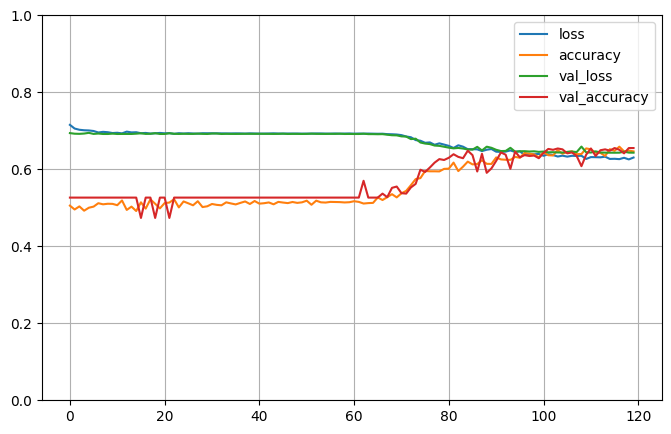


Testing # 1 1
2023-04-06 17:39:06.409034
2023-04-06 17:39:06.409080
PREDICT
2023-04-06 17:39:06.423903
Test 1:0 458:412 52.64%
Predict 1:0 512:358 58.85%
Test sizes (870, 1025) (870,)
Distrib of scores: 0.52549225 mean 0.15463784 std
Range of scores: 0.053756934 to 0.8582055
Score threshold 0.5
Confusion matrix
 [[235 177]
 [123 335]]
Normalized matrix
 [[0.27011494 0.20344828]
 [0.14137931 0.38505747]]
Correct scores pos:neg 143 93
Wrong scores pos:neg 58 30


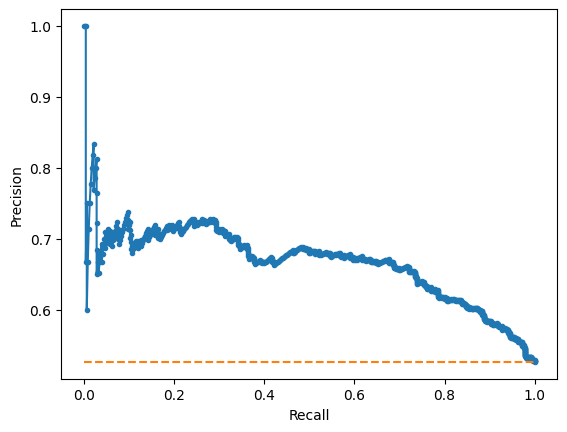

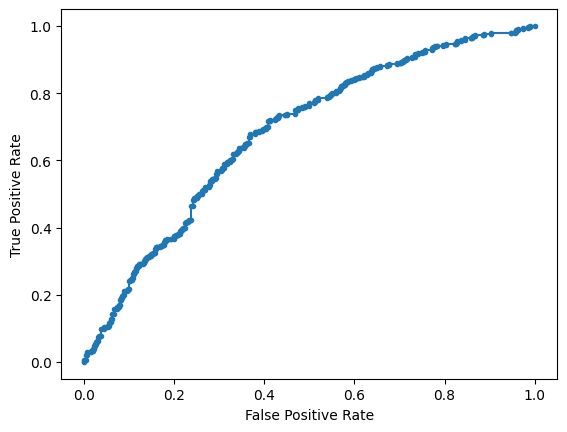

Accuracy: 65.52% Precision: 65.43% Recall: 73.14%
F1: 69.07% MCC: 0.3062
AUPRC: 66.68% AUROC: 68.08%
 accuracy [65.51724137931035]
 precision [65.4296875]
 recall [73.14410480349345]
 F1 [69.0721649484536]
 MCC [0.3062431548163468]
 AUPRC [66.68144655908381]
 AUROC [68.08464408360537]

Training # 1 2
2023-04-06 17:39:07.017356
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-06 17:39:07.031789
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Valid 1:0 442:442 50.00%
FIT
2023-04-06 17:39:07.127201


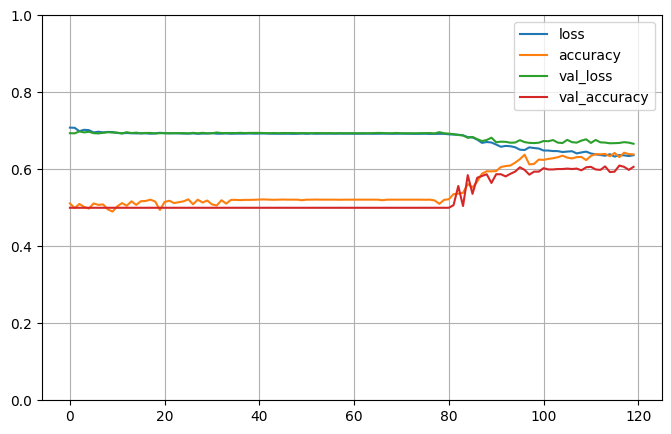


Testing # 1 2
2023-04-06 17:40:31.086673
2023-04-06 17:40:31.086722
PREDICT
2023-04-06 17:40:31.095245
Test 1:0 442:442 50.00%
Predict 1:0 484:400 54.75%
Test sizes (884, 1025) (884,)
Distrib of scores: 0.5143597 mean 0.14824793 std
Range of scores: 0.14383057 to 0.8984229
Score threshold 0.5
Confusion matrix
 [[247 195]
 [153 289]]
Normalized matrix
 [[0.27941176 0.22058824]
 [0.17307692 0.32692308]]
Correct scores pos:neg 107 92
Wrong scores pos:neg 64 40


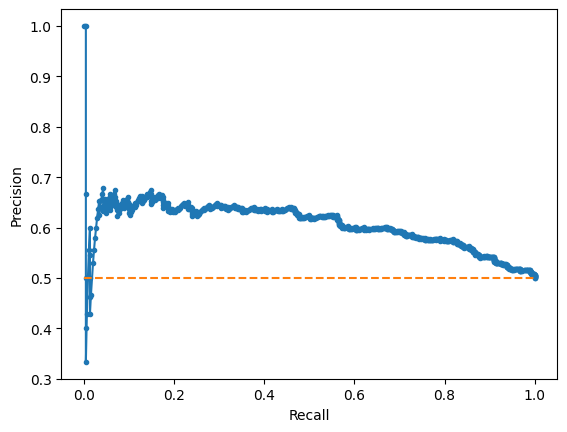

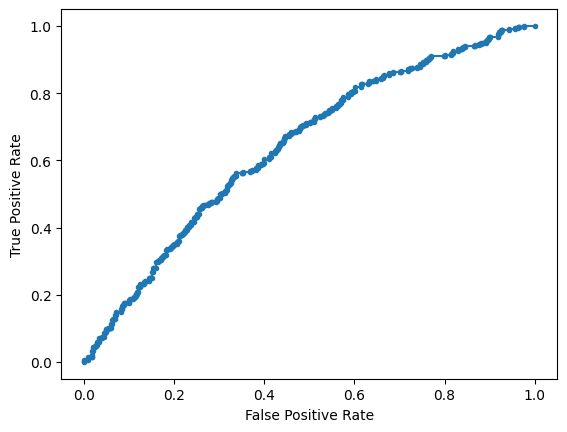

Accuracy: 60.63% Precision: 59.71% Recall: 65.38%
F1: 62.42% MCC: 0.2136
AUPRC: 60.60% AUROC: 64.12%
 accuracy [60.633484162895925]
 precision [59.71074380165289]
 recall [65.38461538461539]
 F1 [62.41900647948163]
 MCC [0.21363636363636362]
 AUPRC [60.60396171322336]
 AUROC [64.12440367723839]

Training # 1 3
2023-04-06 17:40:31.705698
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-06 17:40:31.733280
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Valid 1:0 442:407 52.06%
FIT
2023-04-06 17:40:31.839372


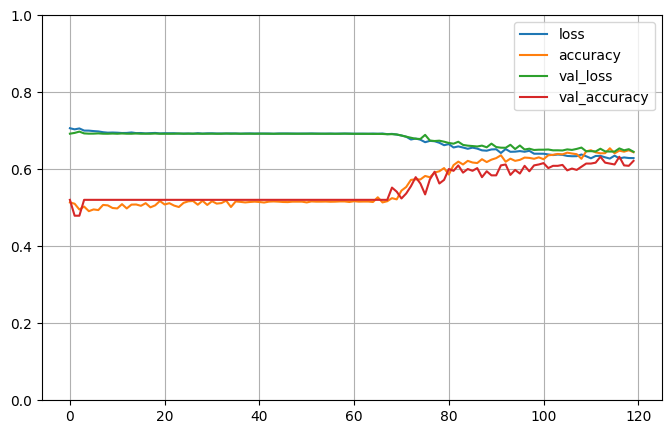


Testing # 1 3
2023-04-06 17:41:55.667238
2023-04-06 17:41:55.667646
PREDICT
2023-04-06 17:41:55.677030
Test 1:0 442:407 52.06%
Predict 1:0 453:396 53.36%
Test sizes (849, 1025) (849,)
Distrib of scores: 0.5124679 mean 0.1559433 std
Range of scores: 0.046910375 to 0.85395867
Score threshold 0.5
Confusion matrix
 [[241 166]
 [155 287]]
Normalized matrix
 [[0.28386337 0.19552415]
 [0.18256773 0.33804476]]
Correct scores pos:neg 121 101
Wrong scores pos:neg 50 36


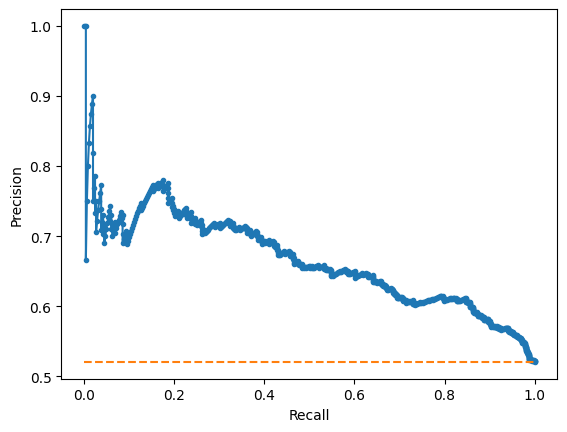

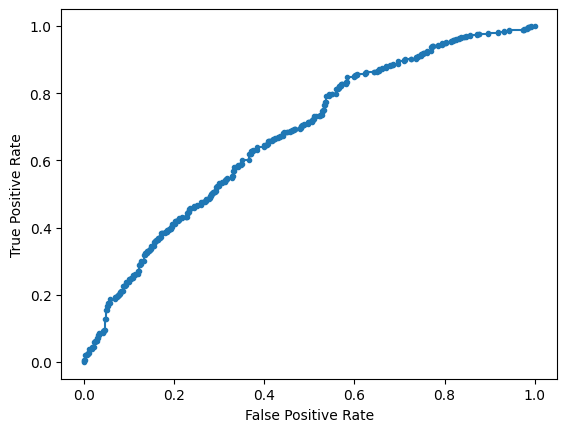

Accuracy: 62.19% Precision: 63.36% Recall: 64.93%
F1: 64.13% MCC: 0.2418
AUPRC: 66.56% AUROC: 67.29%
 accuracy [62.19081272084806]
 precision [63.35540838852097]
 recall [64.93212669683258]
 F1 [64.1340782122905]
 MCC [0.24179916098497273]
 AUPRC [66.56459009997687]
 AUROC [67.28962611315553]

Training # 1 4
2023-04-06 17:41:56.702912
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-06 17:41:56.727912
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Valid 1:0 459:431 51.57%
FIT
2023-04-06 17:41:56.863810


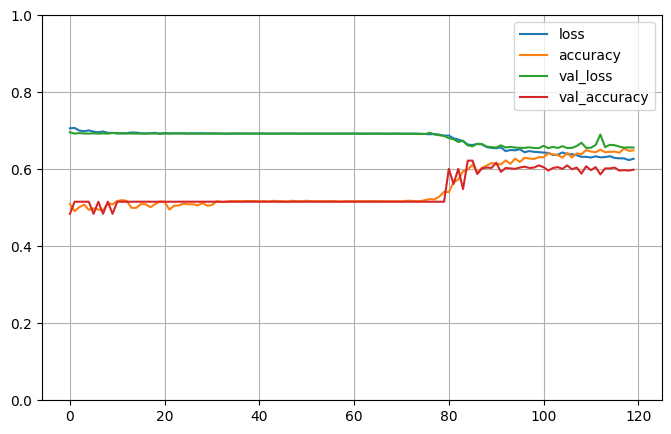


Testing # 1 4
2023-04-06 17:43:20.577338
2023-04-06 17:43:20.577803
PREDICT
2023-04-06 17:43:20.586637
Test 1:0 459:431 51.57%
Predict 1:0 508:382 57.08%
Test sizes (890, 1025) (890,)
Distrib of scores: 0.52781194 mean 0.15910505 std
Range of scores: 0.08916929 to 0.9175018
Score threshold 0.5
Confusion matrix
 [[228 203]
 [154 305]]
Normalized matrix
 [[0.25617978 0.22808989]
 [0.17303371 0.34269663]]
Correct scores pos:neg 147 89
Wrong scores pos:neg 63 29


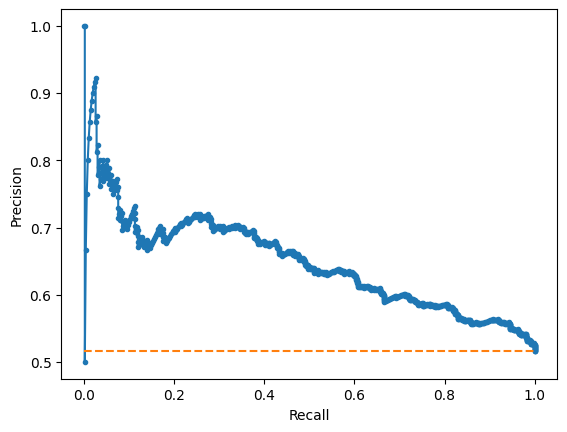

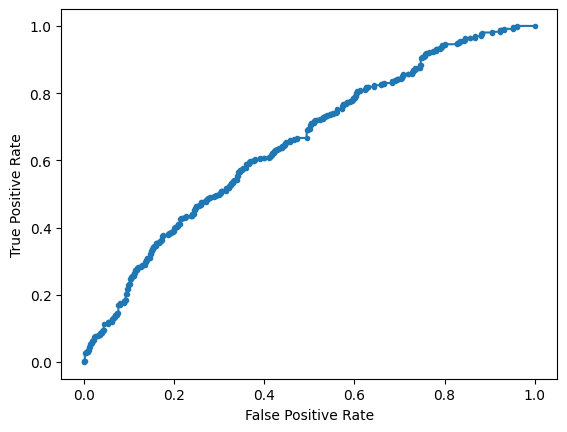

Accuracy: 59.89% Precision: 60.04% Recall: 66.45%
F1: 63.08% MCC: 0.1954
AUPRC: 64.78% AUROC: 65.13%
 accuracy [59.88764044943821]
 precision [60.03937007874016]
 recall [66.4488017429194]
 F1 [63.08169596690797]
 MCC [0.19536228338944142]
 AUPRC [64.77753196016583]
 AUROC [65.12821679329117]

Training # 1 5
2023-04-06 17:43:21.224308
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-06 17:43:21.247641
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Valid 1:0 457:419 52.17%
FIT
2023-04-06 17:43:21.361151


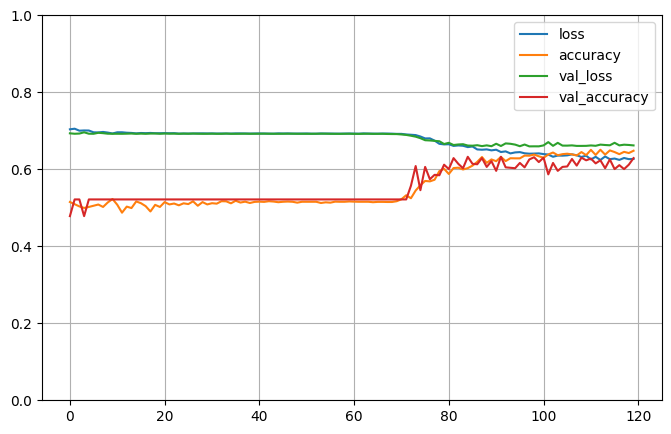


Testing # 1 5
2023-04-06 17:44:22.898327
2023-04-06 17:44:22.898385
PREDICT
2023-04-06 17:44:22.910426
Test 1:0 457:419 52.17%
Predict 1:0 504:372 57.53%
Test sizes (876, 1025) (876,)
Distrib of scores: 0.5282858 mean 0.16247767 std
Range of scores: 0.10425726 to 0.9131349
Score threshold 0.5
Confusion matrix
 [[233 186]
 [139 318]]
Normalized matrix
 [[0.26598174 0.21232877]
 [0.1586758  0.3630137 ]]
Correct scores pos:neg 133 95
Wrong scores pos:neg 70 45


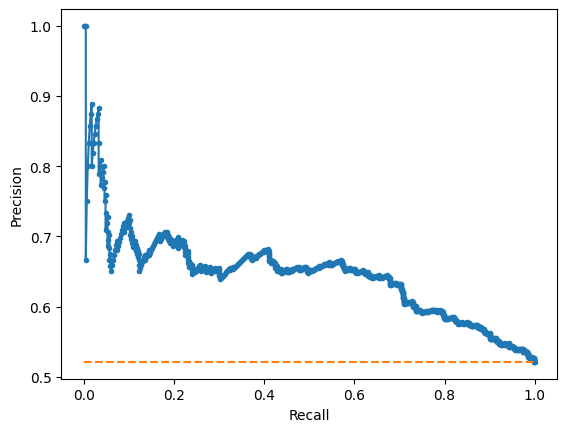

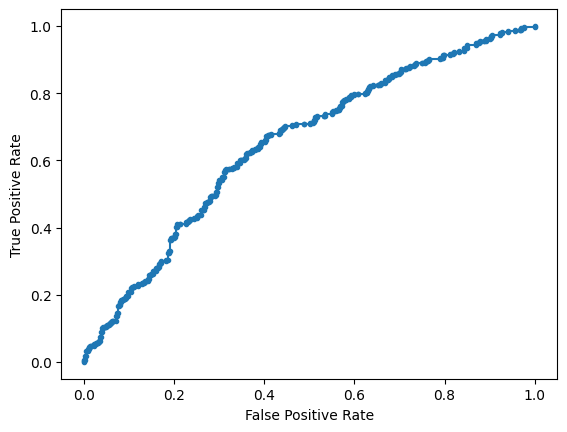

Accuracy: 62.90% Precision: 63.10% Recall: 69.58%
F1: 66.18% MCC: 0.2546
AUPRC: 64.50% AUROC: 64.96%
 accuracy [62.89954337899544]
 precision [63.095238095238095]
 recall [69.58424507658644]
 F1 [66.18106139438085]
 MCC [0.2545982706810659]
 AUPRC [64.49550420276043]
 AUROC [64.95615798791538]

Training # 2 1
2023-04-06 17:44:23.543362
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-06 17:44:23.564712
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Valid 1:0 472:415 53.21%
FIT
2023-04-06 17:44:23.664607


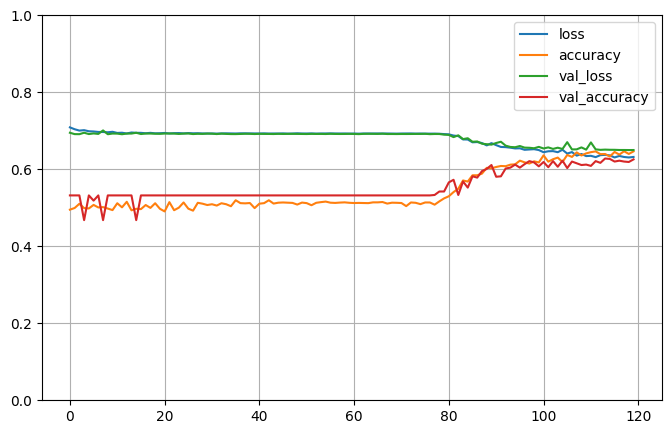


Testing # 2 1
2023-04-06 17:45:46.973436
2023-04-06 17:45:46.973492
PREDICT
2023-04-06 17:45:46.990837
Test 1:0 472:415 53.21%
Predict 1:0 512:375 57.72%
Test sizes (887, 1025) (887,)
Distrib of scores: 0.52341026 mean 0.15019253 std
Range of scores: 0.061410066 to 0.8494481
Score threshold 0.5
Confusion matrix
 [[229 186]
 [146 326]]
Normalized matrix
 [[0.25817362 0.2096956 ]
 [0.16459977 0.367531  ]]
Correct scores pos:neg 132 84
Wrong scores pos:neg 49 38


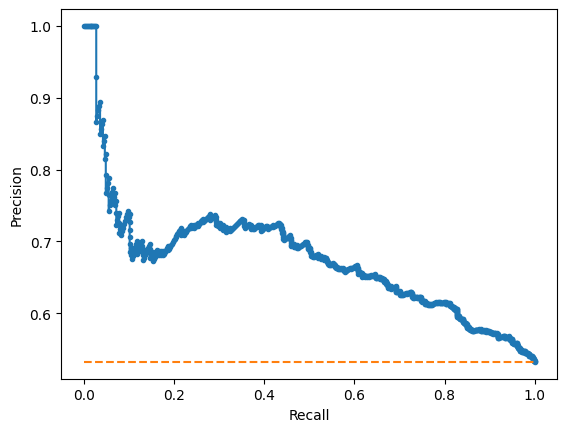

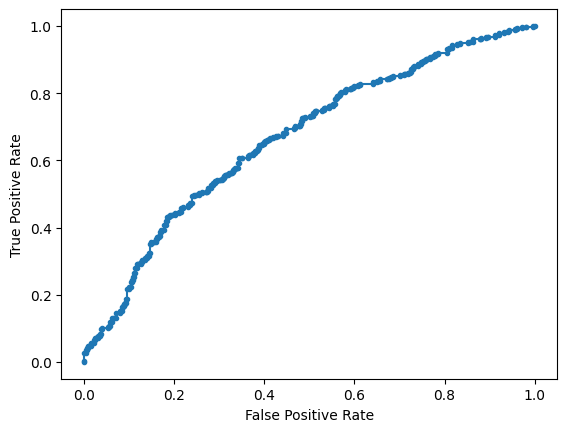

Accuracy: 62.57% Precision: 63.67% Recall: 69.07%
F1: 66.26% MCC: 0.2449
AUPRC: 67.61% AUROC: 66.57%
 accuracy [62.570462232243514]
 precision [63.671875]
 recall [69.0677966101695]
 F1 [66.26016260162602]
 MCC [0.24492305119132196]
 AUPRC [67.60606212543135]
 AUROC [66.5677966101695]

Training # 2 2
2023-04-06 17:45:47.596970
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-06 17:45:47.621828
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Valid 1:0 452:416 52.07%
FIT
2023-04-06 17:45:47.735759


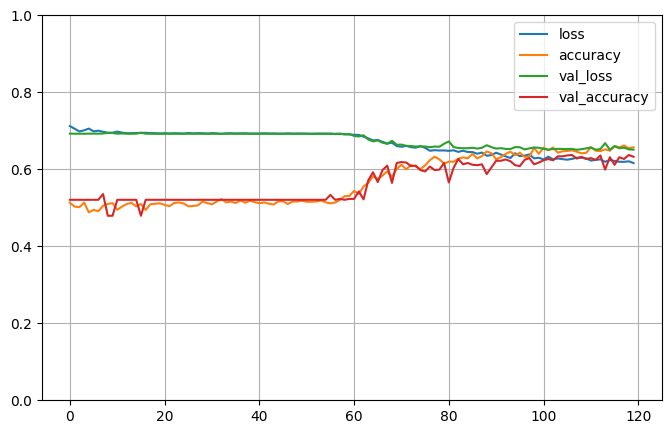


Testing # 2 2
2023-04-06 17:46:50.527935
2023-04-06 17:46:50.527992
PREDICT
2023-04-06 17:46:50.535677
Test 1:0 452:416 52.07%
Predict 1:0 489:379 56.34%
Test sizes (868, 1025) (868,)
Distrib of scores: 0.52163815 mean 0.16884656 std
Range of scores: 0.06849696 to 0.9105712
Score threshold 0.5
Confusion matrix
 [[238 178]
 [141 311]]
Normalized matrix
 [[0.27419355 0.20506912]
 [0.1624424  0.35829493]]
Correct scores pos:neg 141 119
Wrong scores pos:neg 68 48


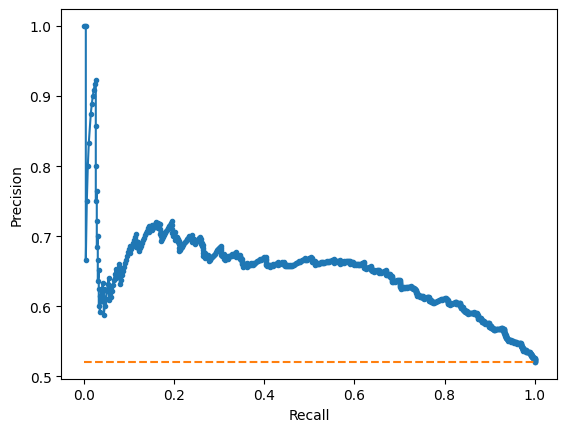

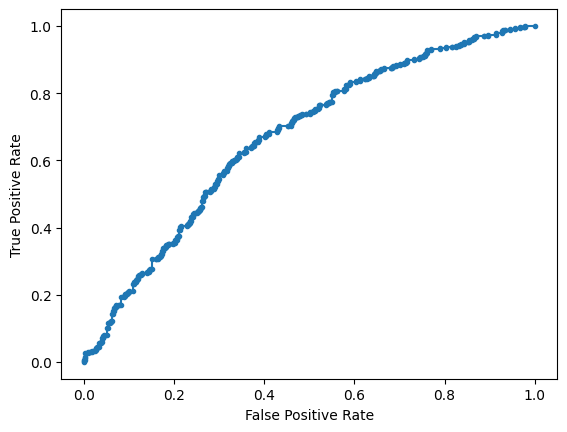

Accuracy: 63.25% Precision: 63.60% Recall: 68.81%
F1: 66.10% MCC: 0.2621
AUPRC: 64.97% AUROC: 66.69%
 accuracy [63.24884792626728]
 precision [63.59918200408998]
 recall [68.80530973451327]
 F1 [66.09989373007438]
 MCC [0.26205746229699356]
 AUPRC [64.966036477116]
 AUROC [66.69024421375084]

Training # 2 3
2023-04-06 17:46:51.171773
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-06 17:46:51.191930
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Valid 1:0 453:407 52.67%
FIT
2023-04-06 17:46:51.284678


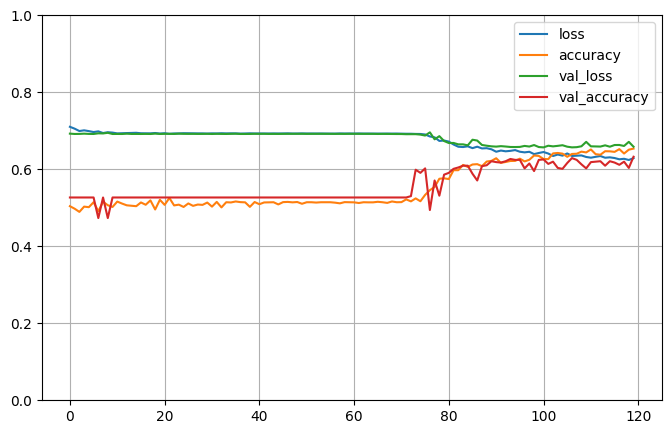


Testing # 2 3
2023-04-06 17:48:14.573489
2023-04-06 17:48:14.573544
PREDICT
2023-04-06 17:48:14.583350
Test 1:0 453:407 52.67%
Predict 1:0 531:329 61.74%
Test sizes (860, 1025) (860,)
Distrib of scores: 0.54430664 mean 0.15596054 std
Range of scores: 0.07863922 to 0.88838243
Score threshold 0.5
Confusion matrix
 [[210 197]
 [119 334]]
Normalized matrix
 [[0.24418605 0.22906977]
 [0.13837209 0.38837209]]
Correct scores pos:neg 155 76
Wrong scores pos:neg 81 29


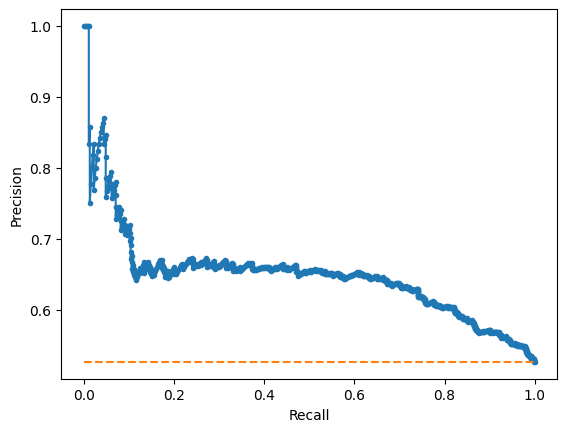

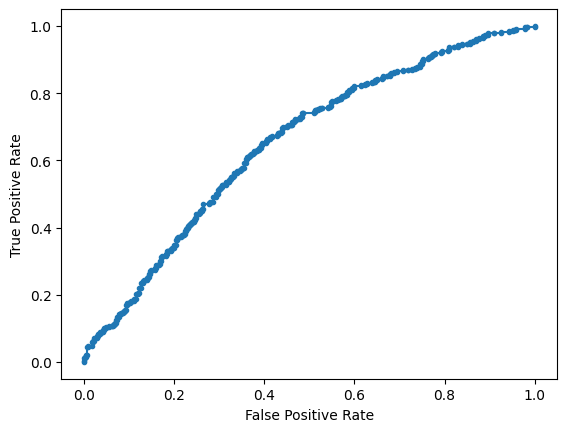

Accuracy: 63.26% Precision: 62.90% Recall: 73.73%
F1: 67.89% MCC: 0.2602
AUPRC: 64.91% AUROC: 65.15%
 accuracy [63.25581395348837]
 precision [62.90018832391714]
 recall [73.73068432671081]
 F1 [67.88617886178861]
 MCC [0.26019411257379116]
 AUPRC [64.91340400192287]
 AUROC [65.15395588243271]

Training # 2 4
2023-04-06 17:48:15.180752
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-06 17:48:15.204520
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Valid 1:0 432:447 49.15%
FIT
2023-04-06 17:48:15.292934


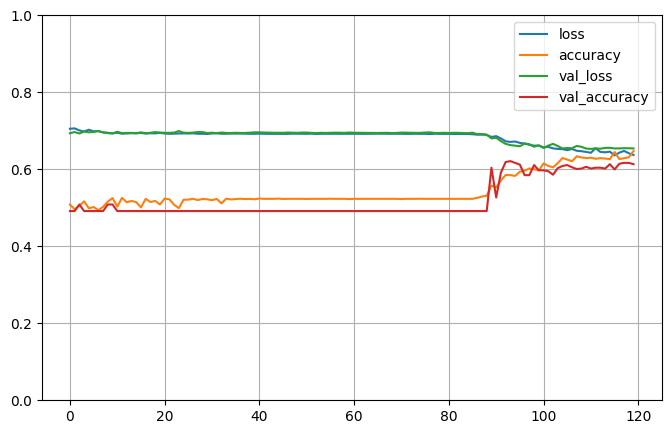


Testing # 2 4
2023-04-06 17:49:39.344418
2023-04-06 17:49:39.344466
PREDICT
2023-04-06 17:49:39.352370
Test 1:0 432:447 49.15%
Predict 1:0 400:479 45.51%
Test sizes (879, 1025) (879,)
Distrib of scores: 0.4924085 mean 0.14585425 std
Range of scores: 0.15098614 to 0.911537
Score threshold 0.5
Confusion matrix
 [[293 154]
 [186 246]]
Normalized matrix
 [[0.33333333 0.17519909]
 [0.2116041  0.27986348]]
Correct scores pos:neg 96 104
Wrong scores pos:neg 44 41


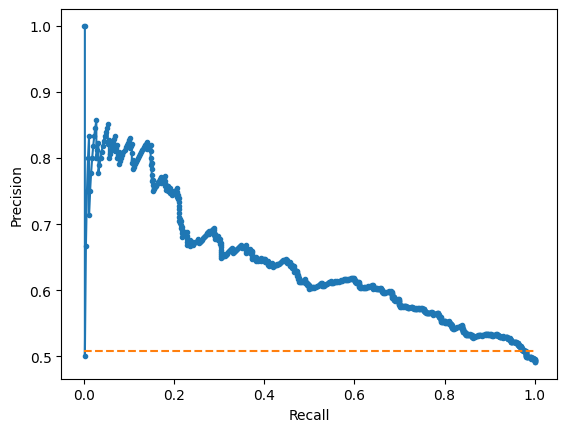

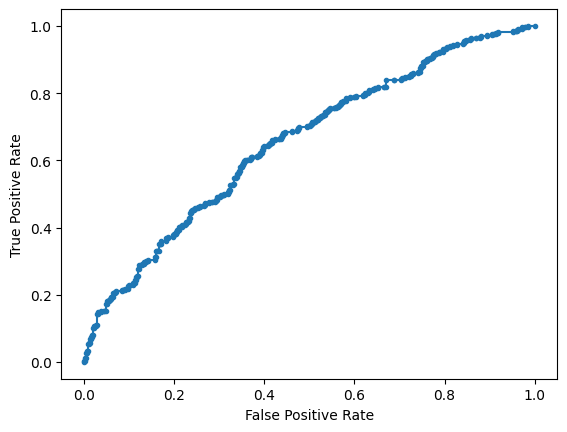

Accuracy: 61.32% Precision: 61.50% Recall: 56.94%
F1: 59.13% MCC: 0.2258
AUPRC: 64.07% AUROC: 65.40%
 accuracy [61.31968145620023]
 precision [61.5]
 recall [56.94444444444444]
 F1 [59.13461538461537]
 MCC [0.2258065002206242]
 AUPRC [64.06732962570203]
 AUROC [65.40206313696245]

Training # 2 5
2023-04-06 17:49:39.997998
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-06 17:49:40.025896
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Valid 1:0 449:426 51.31%
FIT
2023-04-06 17:49:40.129301


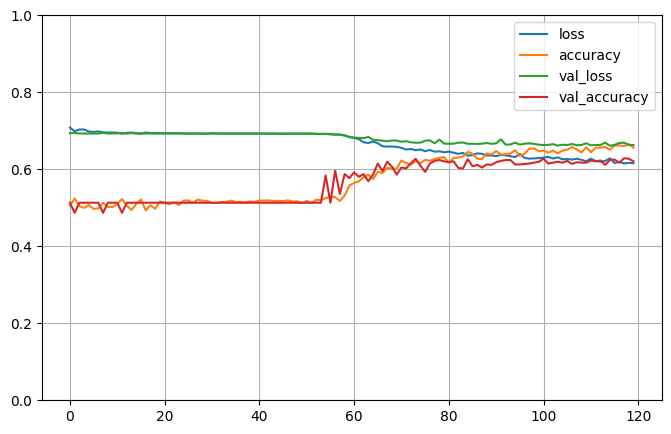


Testing # 2 5
2023-04-06 17:50:43.257918
2023-04-06 17:50:43.257962
PREDICT
2023-04-06 17:50:43.274549
Test 1:0 449:426 51.31%
Predict 1:0 475:400 54.29%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.52313054 mean 0.17485493 std
Range of scores: 0.057068203 to 0.91061777
Score threshold 0.5
Confusion matrix
 [[247 179]
 [153 296]]
Normalized matrix
 [[0.28228571 0.20457143]
 [0.17485714 0.33828571]]
Correct scores pos:neg 139 110
Wrong scores pos:neg 77 37


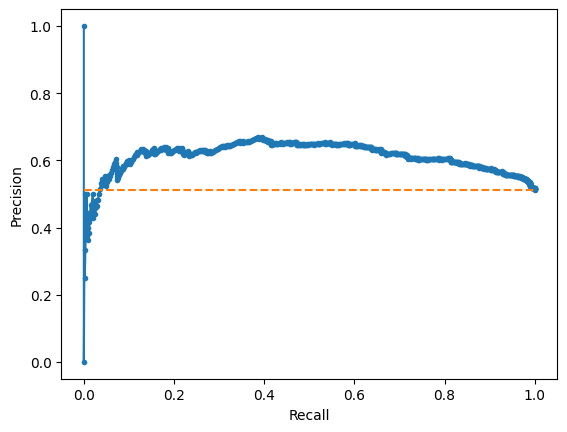

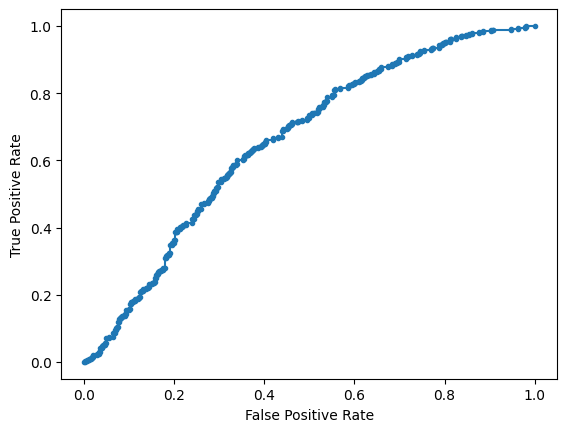

Accuracy: 62.06% Precision: 62.32% Recall: 65.92%
F1: 64.07% MCC: 0.2399
AUPRC: 60.99% AUROC: 65.86%
 accuracy [62.05714285714286]
 precision [62.31578947368421]
 recall [65.92427616926503]
 F1 [64.06926406926407]
 MCC [0.23985509248114506]
 AUPRC [60.98952182501327]
 AUROC [65.86049332371363]
2023-04-06 17:50:43.883513


In [116]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)
           
        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [117]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 62.36% std 1.57
 precision mean 62.56% std 1.74
 recall mean 67.40% std 4.77
 F1 mean 64.83% std 2.89
 MCC mean 0.2444 std 0.0302
 AUPRC mean 64.57% std 2.28
 AUROC mean 65.93% std 1.21
 accuracy [[65.51724137931035], [60.633484162895925], [62.19081272084806], [59.88764044943821], [62.89954337899544], [62.570462232243514], [63.24884792626728], [63.25581395348837], [61.31968145620023], [62.05714285714286]]
 precision [[65.4296875], [59.71074380165289], [63.35540838852097], [60.03937007874016], [63.095238095238095], [63.671875], [63.59918200408998], [62.90018832391714], [61.5], [62.31578947368421]]
 recall [[73.14410480349345], [65.38461538461539], [64.93212669683258], [66.4488017429194], [69.58424507658644], [69.0677966101695], [68.80530973451327], [73.73068432671081], [56.94444444444444], [65.92427616926503]]
 F1 [[69.0721649484536], [62.41900647948163], [64.1340782122905], [63.08169596690797], [66.18106139438085], [66.26016260162602], [66.09989373007438], [67.8861788617